In [2]:
#!/usr/bin/python
import sys
import math
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

#from sympy import Plane, Point3D

import random

# Loading convenient environment
# %pylab
%matplotlib inline

plt.rcParams['figure.figsize']=[20.,10.]

In [3]:
def ccw(A,B,C):
    return (C[1]-A[1]) * (B[0]-A[0]) > (B[1]-A[1]) * (C[0]-A[0])

# Return true if line segments AB and CD intersect
def intersect(A,B,C,D):
    return ccw(A,C,D) != ccw(B,C,D) and ccw(A,B,C) != ccw(A,B,D)

In [4]:
# What are the morphology parameters of influence:
#   - shape of flakes: hexagonal, even circle is fine.. > no "hard" angle (bigger than pi/2.), "natural" shape of ideal flakes
#   - size of flakes: 10-15µm
#   - orientation of flakes: based on one angle and one direction (in the plane of the graphene flake),
#                            direction of load, orthogonal direction of load, random uniform, random with spatial correlation
#   - position/dispersion: regularly disperse, non-crossing of flakes or boundaries
#   - weight ratio: 0.08%, 0.16%
#   - number of flakes: weight ratio > total mass of flakes > number=total mass of flakes/mass of a single flake


# Ex: vcell=150.0e-6*50.0e-6*50.0e-6 & mratio=0.16% & lflake=10µm > 31 flakes
#     if lcell=5µm > ncell=3000 ~ 4 cells/flake

In [5]:
# Parameters of graphene flakes
smass_flake = 0.00077
diam_flake = 10.0e-6
mass_flake = smass_flake*diam_flake**2.0/4.0
thick_flake = 1.0e-9

# Orientation of flakes
referential_flake = np.identity(3) # local referential of the flake (xf and yf define the plane of the flake, zf the normal)

In [6]:
# Parameters of epoxy (ideally to be passed as argument)
dens_epoxy = 1000.
size_sample = [50.0e-6, 150.0e-6, 50.0e-6]
vol_sample = size_sample[0]*size_sample[1]*size_sample[2]
mass_epoxy = dens_epoxy*vol_sample

size_cell = [5.0e-6, 5.0e-6, 5.0e-6]
#vol_cell = size_cell[0]*size_cell[1]*size_cell[2]

In [42]:
# Parameters of composite
mass_ratio =0.0001
mass_graphene = mass_epoxy*mass_ratio

In [43]:
# Number of flakes in sample
nb_flakes = int(mass_graphene/mass_flake)
print(nb_flakes)

1


In [49]:
# Position of flakes
flakes_data = pd.DataFrame(columns=['cx','cy','cz','diam','nx','ny','nz','thick'])
for n in range(nb_flakes):
    print('Inserting flake #',n,'...')
    ktry=0
    while True:
        ktry+=1
        print('   attempt #',ktry,'...')
        
        tc=pd.Series(index=flakes_data.columns)
        
        # Flake position
        tc['cx']=random.uniform(0.0+diam_flake, size_sample[0]-diam_flake)
        tc['cy']=random.uniform(0.0+diam_flake, size_sample[1]-diam_flake)
        tc['cz']=random.uniform(0.0+diam_flake, size_sample[2]-diam_flake)
        
        # Flake dimension (here diameter)
        tc['diam'] = diam_flake
        
        # Flake thickness
        tc['thick'] = thick_flake
        
        # Flake orientation (normal direction to flake plane)
        tc['nx'] = random.uniform(-1.0,1.0)
        tc['ny'] = random.uniform(-1.0,1.0)
        tc['nz'] = random.uniform(-1.0,1.0)
        nrm = (tc['nx']**2.0+tc['ny']**2.0+tc['nz']**2.0)**0.5
        tc['nx']=tc['nx']/nrm
        tc['ny']=tc['ny']/nrm
        tc['nz']=tc['nz']/nrm
        
        valid_flake = True
        
        # How to check if two flakes with different angles are intersecting?
        for m in range(len(flakes_data.index)):
            cc=flakes_data.iloc[m]
            
            # distance in between centers
            dist=(((tc['cx']-cc['cx'])**2.0+(tc['cy']-cc['cy'])**2.0+(tc['cz']-cc['cz'])**2.0)**0.5)
            
            # if distance between centers below sum of radii, keep checking, 
            # otherwise test next candidate
            if(dist<(tc['diam']/2.0+cc['diam']/2.0)):
                # centers coordinates
                tcc = [tc['cx'],tc['cy'],tc['cz']]
                ccc = [cc['cx'],cc['cy'],cc['cz']]
                
                # normal vectors
                tcn = [tc['nx'],tc['ny'],tc['nz']]
                ccn = [cc['nx'],cc['ny'],cc['nz']]
                
                # normal vector to plan containing normal vectors
                p = np.cross(tcn, ccn)
                
                # Intersection line of 'tc' with plan defined by p
                nAB = np.cross(p, tcn)
                A = -tc['diam']*nAB+tcc
                B = tc['diam']*nAB+tcc
                
                # Intersection line of 'cc' with plan defined by p
                nCD = np.cross(p, ccn)
                C = -cc['diam']*nCD+ccc
                D = cc['diam']*nCD+ccc
                
                # define a referential in plane defined by p and nAB
                p1 = p
                p2 = nAB
                p3 = np.cross(p1, nAB)
                
                # Project A, B, C & D on plane (p2,p3)
                pA = [np.dot(A,p2),np.dot(A,p3)]
                pB = [np.dot(B,p2),np.dot(B,p3)]
                pC = [np.dot(C,p2),np.dot(C,p3)]
                pD = [np.dot(D,p2),np.dot(D,p3)]
                
                # Checking if AB and CD intersect? If so, disks intersect...
                if intersect(pA,pB,pC,pD):
                    valid_flake = False
            
        if (valid_flake == True):
            break
    
    flakes_data = flakes_data.append(tc,ignore_index=True)

Inserting flake # 0 ...
   attempt # 1 ...


In [50]:
np.dot(p2,p3)

TypeError: unsupported operand type(s) for *: 'float' and 'module'

In [51]:
flakes_data

,cx,cy,cz,diam,nx,ny,nz,thick
0,0.000024,0.000034,0.000021,0.00001,-0.211939,0.798287,0.563754,1.000000e-09


In [52]:
# Offset position of flakes so the sample is centered on the origin
flakes_data['cx'] = flakes_data['cx'] - size_sample[0]/2.
flakes_data['cy'] = flakes_data['cy'] - size_sample[1]/2.
flakes_data['cz'] = flakes_data['cz'] - size_sample[2]/2.

In [53]:
file = open('flakes_data.csv','w')
file.write(str(len(flakes_data.index))+','+str(len(flakes_data.columns))+'\n')
flakes_data.to_csv(file,header=True,index=False)
file.close()

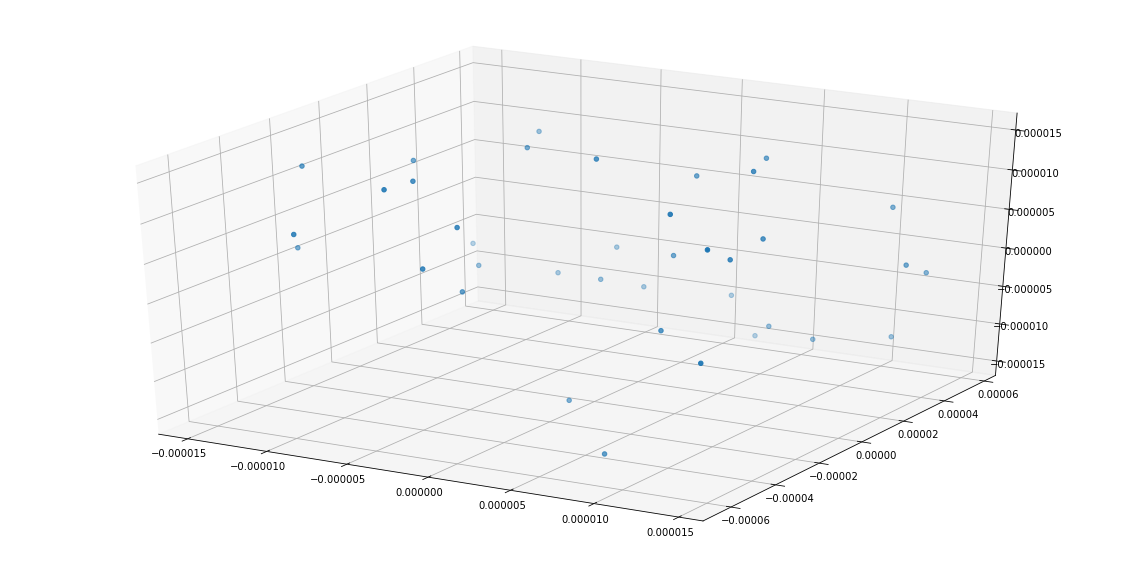

In [14]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(flakes_data['cx'],flakes_data['cy'],flakes_data['cz'])
#for m in range(1):

In [41]:
import ipyvolume.pylab as p3
import numpy as np

p3.figure()
s = p3.ipv.quickscatter(flakes_data['cx'],flakes_data['cy'],flakes_data['cz'], size=1, marker="sphere")
# p3.xlim(0., 50e-6)
p3.xyzlim(0., 150e-6)
# p3.zlim(0., 50e-6)
p3.style.use("dark")
p3.show()

VBox(children=(Figure(camera_center=[0.0, 0.0, 0.0], height=500, matrix_projection=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], matrix_world=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scatters=[Scatter(color_selected=array('white',
      dtype='<U5'), geo='sphere', size=array(1), size_selected=array(2.6), x=array([ -8.42453589e-06,  -8.87801550e-06,  -5.30536340e-06,
         1.15475213e-05,  -7.82084303e-06,   1.49964997e-05,
         7.09998221e-06,   8.44218273e-06,  -1.23265790e-05,
        -5.16420975e-06,   1.40919136e-05]), y=array([ -1.54929763e-05,   4.54343585e-05,  -3.20410181e-05,
         1.63199585e-05,  -1.45674170e-05,   2.80161060e-05,
        -2.41474458e-06,   6.36068411e-05,   2.61841144e-05,
        -2.40649374e-05,  -7.27229396e-06]), z=array([  5.13312820e-06,  -8.94723875e-06,  -8.72842238e-06,
         1.11289493e-05,  -1.33276726e-05,  -2.63626898e-06,
        -6.54833560e-06,   7.73541008e-06,  -9.14734167e-06,
         1.31266006e-05,   1.16199338e-05]))], style={'axes': {'visible': True, 'label': {'color': 'white'}, 'ticklabel': {'color': 'white'}, 'color': 'white'}, 'box': {'visible': True}, 'background-color': 'black'}, tf=None, width=400, xlim=[0.0, 0.00015], ylim=[0.0, 0.00015], zlim=[0.0, 0.00015]),))